In [2]:
# Ensure relevant packages are installed
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install biopython
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install hyperopt

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=6bcbc5c064a6c4f23edd858c628f179ca48892eea5521d42dda59f0f97c5509c
  Stored in directory: /home/marie/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
     |████████████████████████████████| 1.6 MB 963 kB/s eta 0:00:01


     |████████████████████████████████| 198 kB 2.5 MB/s eta 0:00:01


In [8]:
from Bio import SeqIO
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
"""
Does not work

#Encode a single protein sequence into a vector with 96*20 = 1920 binary variables
def one_hot_encoder(MSA_str, alphabet):
    # define a mapping of characters to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in MSA_str]
    # one hot encode integers
    onehot_encoded = list()
    for value in integer_encoded:
        if value == char_to_int.get("-"):
            letter = [0 for value in range(len(alphabet)-1)]
        else:
            letter = [0 for value in range(len(alphabet)-1)]
            letter[value] = 1
        onehot_encoded.append(letter)
        
    #At this point, we have 96 vectors of 20 binary variables, one vector per letter
    #Concatenate them to have one vector of 1920 variables
    concatenated = onehot_encoded[0]
    for i in range(len(onehot_encoded)-1):
        concatenated = np.concatenate((concatenated, onehot_encoded[i+1]), axis = None)
        
    return concatenated"""
#One-hot encoder

def one_hot_encoder(sequence, alphabet):
    """
    Input : sequence "--ATCGQRT-W-" for instance
    Output : numpy array, one line = one amino acid hot-encoded (or gap -)
    """
    X_in_seq = "X" in sequence
    if X_in_seq == True :
        return "to_remove"
    else :
        m = np.eye(20) #identity matrix, 20 amino acids
        m = np.vstack([m, np.zeros(20)]) #add zero line for '-', same length as amino acids hot encoding
        mapping = dict(zip(("ACDEFGHIKLMNPQRSTVWY-"), range(21))) #mapping of the sequence to encode
        sequence_mapped = [mapping[i] for i in sequence] #mapped sequence ("ACDE-" --> [0,1,2,3,20])  
        return m[sequence_mapped].reshape(len(sequence)*20) #takes the line of 0&1s from m that corresponds to the mapping

#test 
#one_hot_encode("AD-")

In [6]:
#Use one_hot_encoder on all the elements in one file: end up with N vectors of 1920 variables
def read_and_encode(file, alphabet):
    
    #Store relevant data in dictionary
    #Keys: sequence_number; values: sequence, functionality (functional_true, functional_false)
    data_dict = {}
    index=1
    #name sequences as "sequence_#": do this in roundabout way since third file does not name thep thus
    for seq_record in SeqIO.parse(file, "fasta"):
        data_dict['sequence_' + str(index)] = seq_record.seq
        index += 1
        data_dict[seq_record.id] = seq_record.seq, seq_record.description.replace(seq_record.id+' ','',1)
    
    #Array one: one vector per string => [N, 20*92]
    encoded_data = np.empty([len(data_dict), (len(alphabet)-1)*(len(data_dict['sequence_1'][0]))])
    #Array 2: one binary label per string => [N]
    labels = np.empty(len(data_dict))
    
    #Encode every sequence in the file
    for i in range(len(data_dict)):
        sequence = data_dict.get("sequence_"+str(i+1))[0] #this [0] makes the function crash for the unlabeled file
        encoded_data[i] = one_hot_encoder(sequence, alphabet)
        
        #if functional_true => encode 1 in labels
        if data_dict.get("sequence_"+str(i+1))[1] == "functional_true":
            labels[i]=1
        #if functional_false => encode 0 in labels
        elif data_dict.get("sequence_"+str(i+1))[1] == "functional_false":
            labels[i]=0
      
    return encoded_data, labels

#Slightly different for unlabelled data
def read_and_encode_unlab(file, alphabet):
    data_dict = {}
    index=1
    for seq_record in SeqIO.parse(file, "fasta"):
        data_dict['sequence_' + str(index)] = seq_record.seq
        index += 1

    encoded_data_unlab = np.empty([len(data_dict), 1920])
    number_of_corrupted_lines = 0
    corrupted_indexes = []

    for i in range(len(data_dict)):
        sequence = data_dict.get("sequence_"+str(i+1))
        #Some Xs are hanging around in the files, need to avoid them
        try:
            encoded_data_unlab[i] = one_hot_encoder(sequence, alphabet)
        except:
            corrupted_indexes.append(i)
            number_of_corrupted_lines += 1

    print("The number of corrupted sequences is "+ str(number_of_corrupted_lines))

    for i in range(len(corrupted_indexes)):
        encoded_data_unlab = np.delete(encoded_data_unlab, i, axis = 0)
    return encoded_data_unlab

In [7]:
#Read files
#Check that everything works
alphabet ='ACDEFGHIKLMNPQRSTVWY-' #the alphabet we'll use the whole time

encoded_data_nat, labels_nat = read_and_encode("./MSA_nat_with_annotation.faa", alphabet)
print("The shapes of the oneshot encoded natural data and of the label files are " + str(np.shape(encoded_data_nat)) + " and " + str(np.shape(labels_nat))+" respectively")

encoded_data_art, labels_art = read_and_encode("./MSA_art.faa", alphabet)
print("The shapes of the oneshot encoded artificial data and of the label files are " + str(np.shape(encoded_data_art)) + " and " + str(np.shape(labels_art))+" respectively")

all_lab_data = np.concatenate((encoded_data_art, encoded_data_nat))
all_lab = np.concatenate((labels_nat, labels_art))
print("The shapes of all the oneshot encoded labeled data and of their label file are " + str(np.shape(all_lab_data)) + " and " + str(np.shape(all_lab))+" respectively")

encoded_data_unlab = read_and_encode_unlab("./MSA_nat_no_annotation.faa", alphabet)
print("The shape of the oneshot encoded unlabeled data is " + str(np.shape(encoded_data_unlab)))

NameError: name 'one_hot_encoder' is not defined

In [57]:
from Bio import SeqIO
import sys
import numpy as np

encoded_data_art = [one_hot_encode(entry.seq) for entry in SeqIO.parse("MSA_art.faa", "fasta")] #artificial sequences
encoded_data_unlab = [one_hot_encode(entry.seq) for entry in SeqIO.parse("MSA_nat_no_annotation.faa", "fasta")]#natural without annotation
encoded_data_nat = [one_hot_encode(entry.seq) for entry in SeqIO.parse("MSA_nat_with_annotation.faa", "fasta")] #natural
encoded_data_unlab = [item for item in encoded_data_unlab if item != "to_remove"]

#full_data = art + nat_no + nat_yes
#annot_data = art + nat_yes
all_lab_data = np.concatenate((encoded_data_art,encoded_data_nat))


In [58]:
labels_nat = [1 if "true" in entry.description else 0 for entry in SeqIO.parse("MSA_nat_with_annotation.faa", "fasta")]
labels_art = [1 if "true" in entry.description else 0 for entry in SeqIO.parse("MSA_art.faa", "fasta")]

#func_annot_data = func_art + func_nat_yes
all_lab = np.concatenate((labels_art, labels_nat))

In [59]:
#Exercice 2: apply PCA
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt

#Standardizing the features: not needed - data is already scaled. But if we did:
#from sklearn.preprocessing import StandardScaler
#encoded_data = StandardScaler().fit_transform(encoded_data)
def apply_PCA(encoded_data):

    #Find number of components such that we keep, say, 95% of the variance when applying
    pca_test = PCA().fit(encoded_data)
    n_components= np.where(np.cumsum(pca_test.explained_variance_ratio_) > 0.95)
    min_n = n_components[0][0]
    print("With " + str(min_n) + " components, we keep 95% of the variance!")
    
    fig = plt.figure(figsize=(8,8))
    plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
    plt.axvline(x=min_n, color='red', linestyle='--')
    plt.xlabel("number of components")
    plt.ylabel("cumulative explained variance")

    
    #Apply PCA with this optimal n
    pca = PCA(n_components=min_n)
    pcs_nat = pca.fit_transform(encoded_data_nat)
    principalComponents = pca.transform(encoded_data)

    two_compo_var = (pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1])*100
    print("With the first 2 components, we only keep " + str(two_compo_var) + "% of the variance")
    
    return principalComponents

#Visualize the first two principle components
def visualize_pcs(principalComponents, labels, title):
    #red => 0 => functional_false; green => 1 => functional_true
    if(labels is None):
        colors = []
    else:
        colors = ['red','green']
        
    fig = plt.figure(figsize=(8,8))
    plt.scatter(principalComponents[:,0], principalComponents[:,1], c=labels, marker = '+', 
                cmap=matplotlib.colors.ListedColormap(colors))
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title(title ,fontsize=20)

We have 1130 natural labelled sequences
With 501 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.638790852685845% of the variance
We have 1003 artificial labelled sequences
With 312 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.638790852685835% of the variance
We have 2133 labelled sequences
With 529 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.638790852685825% of the variance
We have 6269 unlabelled sequences
With 512 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.638790852685835% of the variance


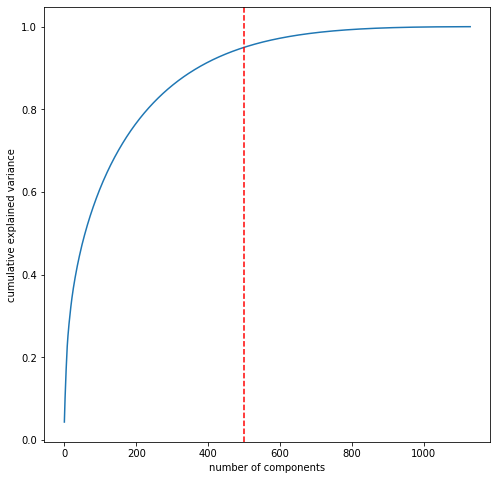

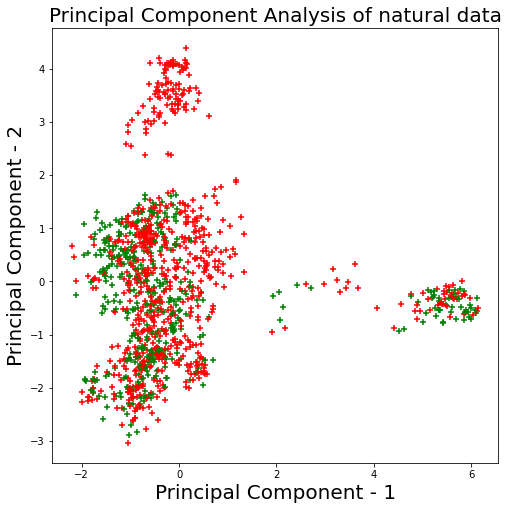

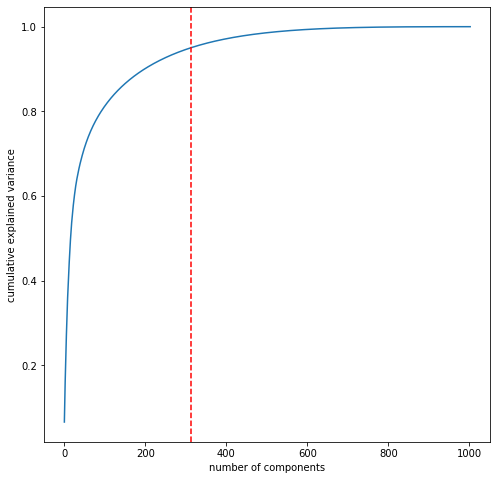

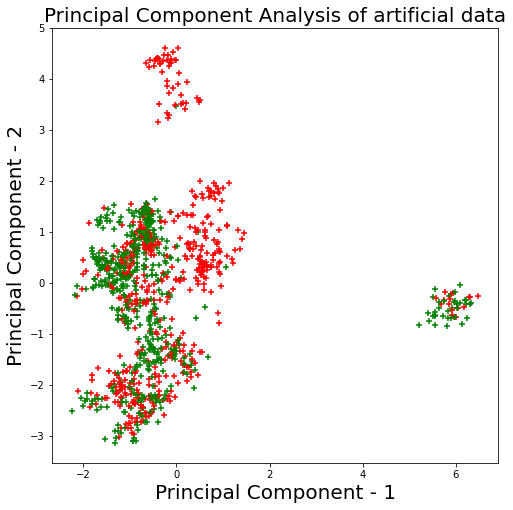

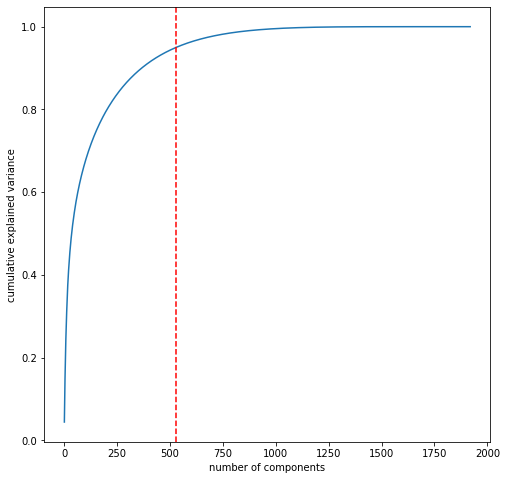

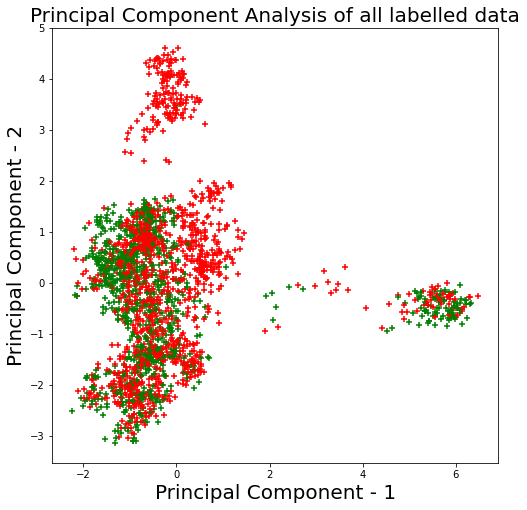

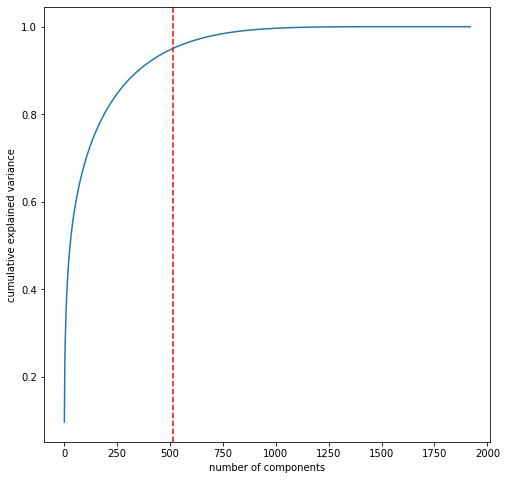

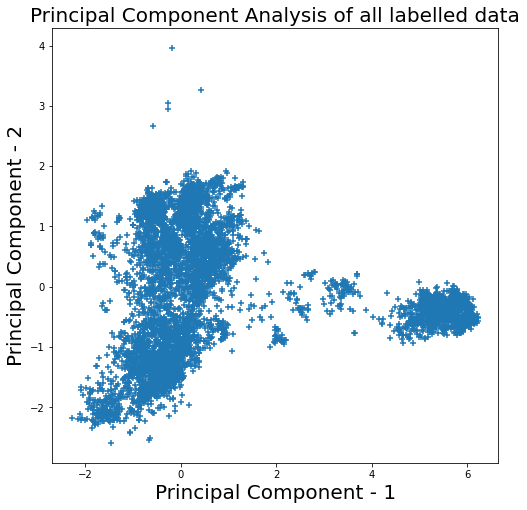

In [60]:
#Try this way, but we'll do it like above I guess
print("We have " + str(np.shape(encoded_data_nat)[0]) + " natural labelled sequences")
pcs_nat = apply_PCA(encoded_data_nat)
visualize_pcs(pcs_nat, labels_nat, "Principal Component Analysis of natural data")

print("We have " + str(np.shape(encoded_data_art)[0]) + " artificial labelled sequences")
pcs_art = apply_PCA(encoded_data_art)
visualize_pcs(pcs_art, labels_art, "Principal Component Analysis of artificial data")

print("We have " + str(np.shape(all_lab_data)[0]) + " labelled sequences")
pcs_all = apply_PCA(all_lab_data)
visualize_pcs(pcs_all, all_lab, "Principal Component Analysis of all labelled data")

print("We have " + str(np.shape(encoded_data_unlab)[0]) + " unlabelled sequences")
pcs_unlab = apply_PCA(encoded_data_unlab)
visualize_pcs(pcs_unlab, None, "Principal Component Analysis of all labelled data")

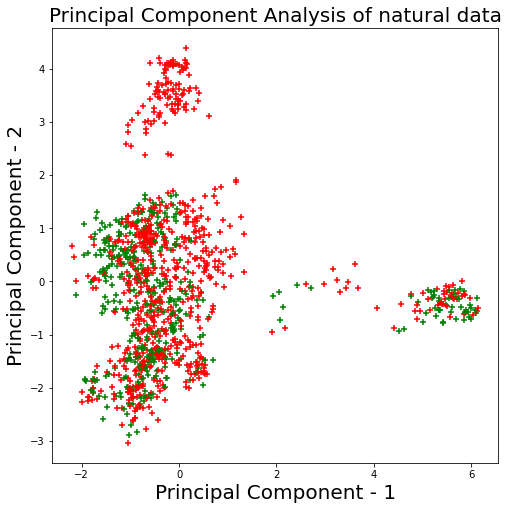

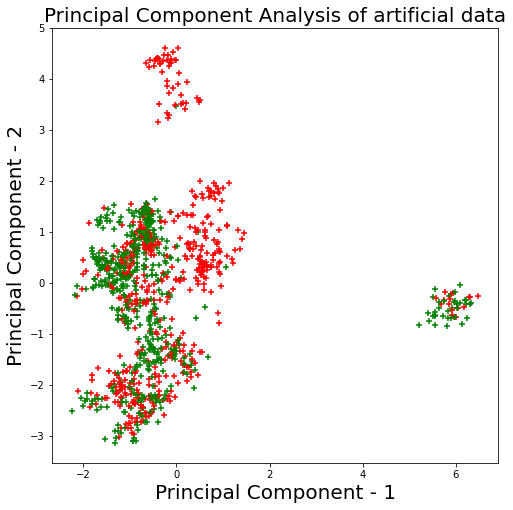

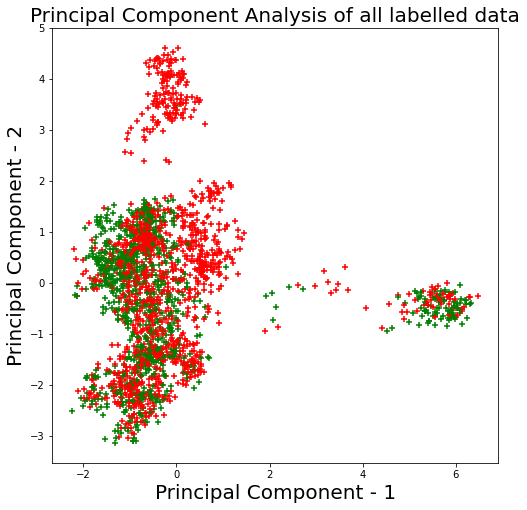

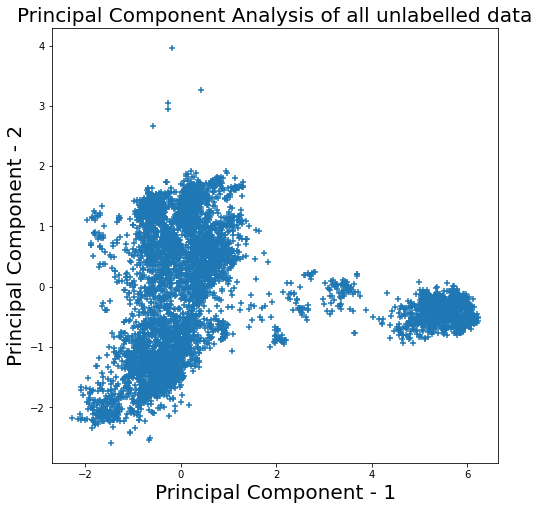

In [76]:
#We'll use 500
modelPCA = PCA(n_components=500)

nat_pcs = modelPCA.fit_transform(encoded_data_nat)
art_pcs = modelPCA.transform(encoded_data_art)
all_pcs = modelPCA.transform(all_lab_data)
unlab_pcs = modelPCA.transform(encoded_data_unlab)

visualize_pcs(nat_pcs, labels_nat, "Principal Component Analysis of natural data")
visualize_pcs(art_pcs, labels_art, "Principal Component Analysis of artificial data")
visualize_pcs(all_pcs, all_lab, "Principal Component Analysis of all labelled data")
visualize_pcs(unlab_pcs, None, "Principal Component Analysis of all unlabelled data")

In [77]:
#Exercice 3: clustering

from sklearn.cluster import AgglomerativeClustering

def compo_cluster(data, pcs, title, n):

    method = AgglomerativeClustering(n_clusters = n)
    clustered = method.fit(data)
    labels = clustered.labels_
    colors = ['red','green']

    fig = plt.figure(figsize=(8,8))
    plt.scatter(pcs[:,0], pcs[:,1], c=labels, marker = '+')
            #cmap=matplotlib.colors.ListedColormap(colors))
    plt.xlabel('Principal Component - 1',fontsize=20)
    plt.ylabel('Principal Component - 2',fontsize=20)
    plt.title(title)

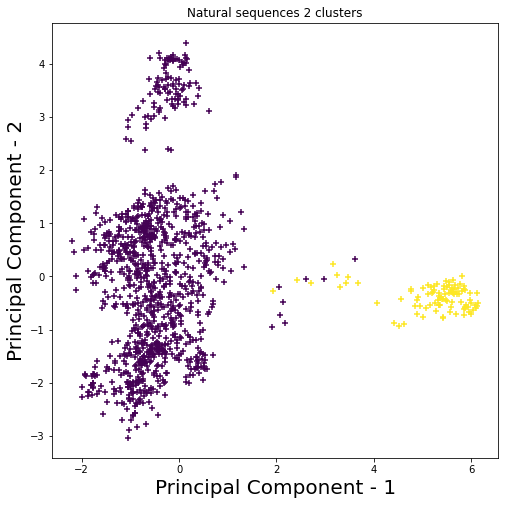

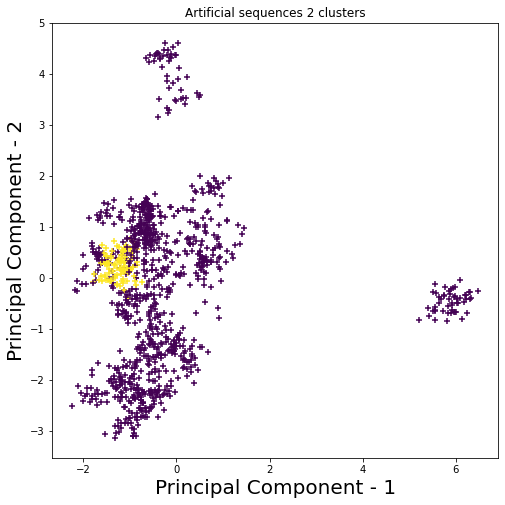

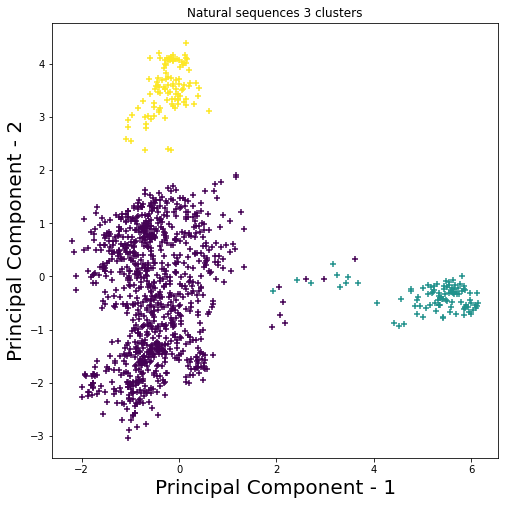

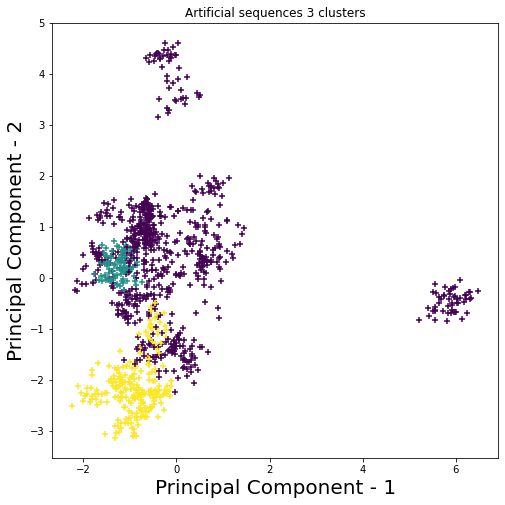

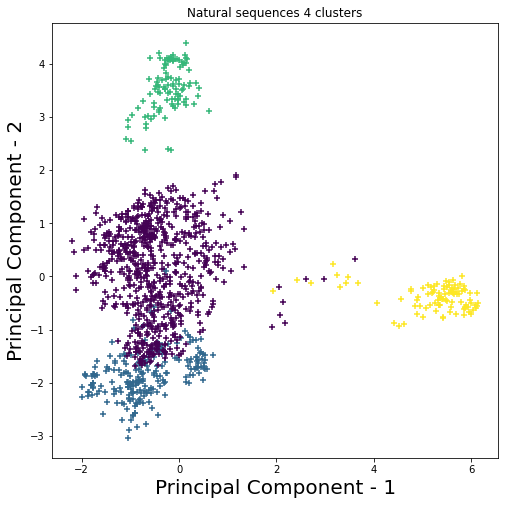

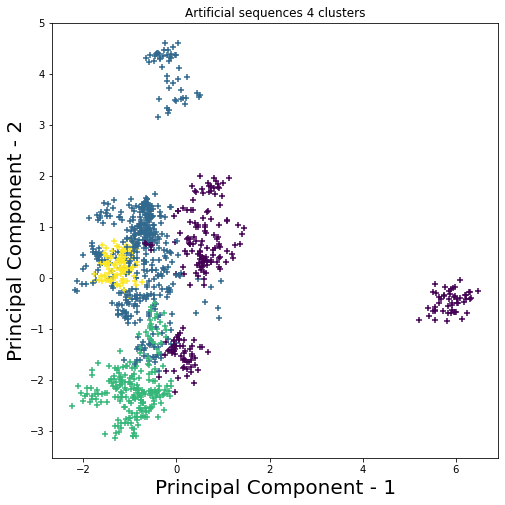

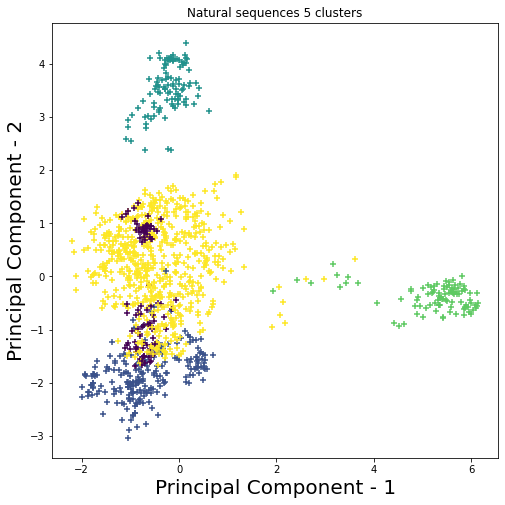

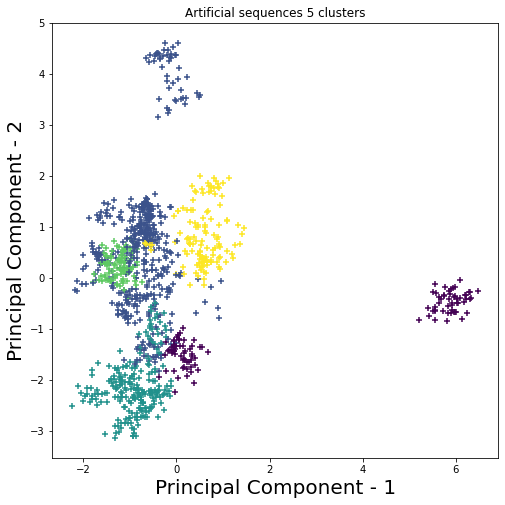

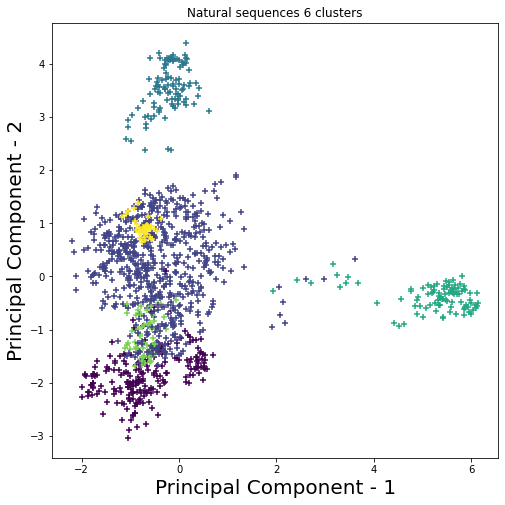

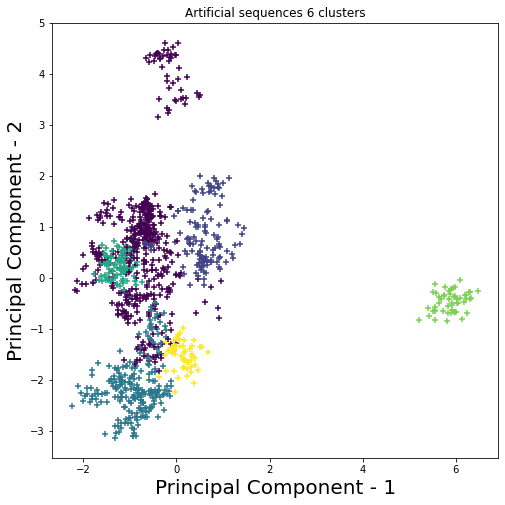

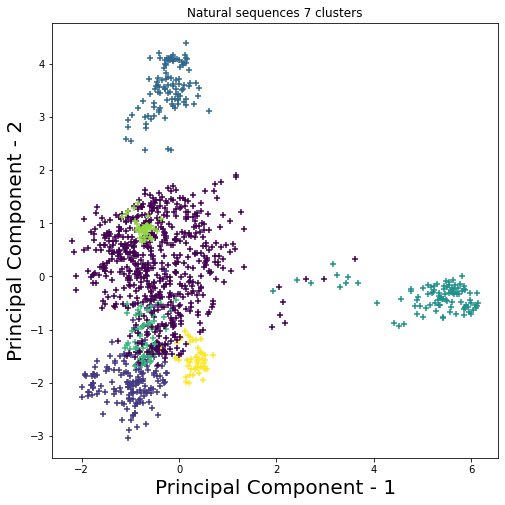

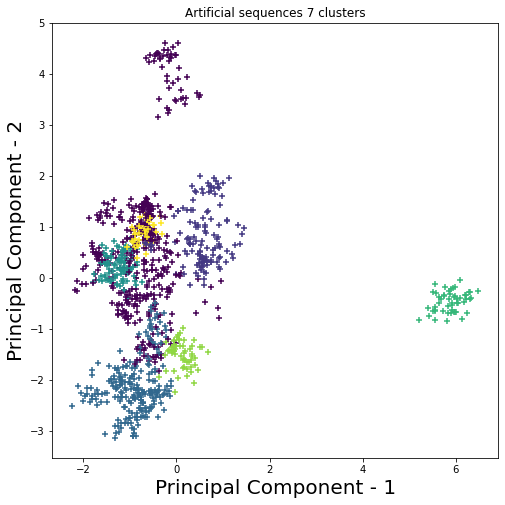

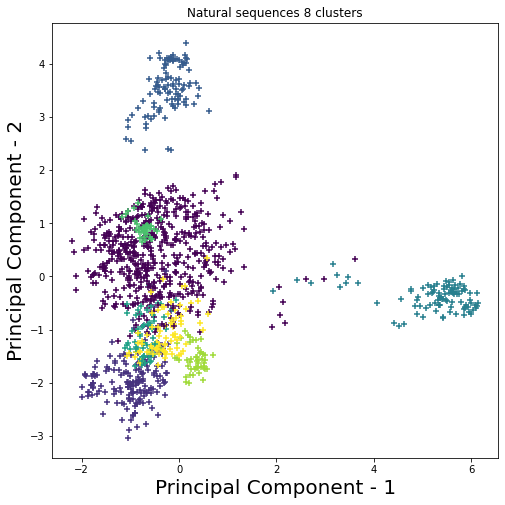

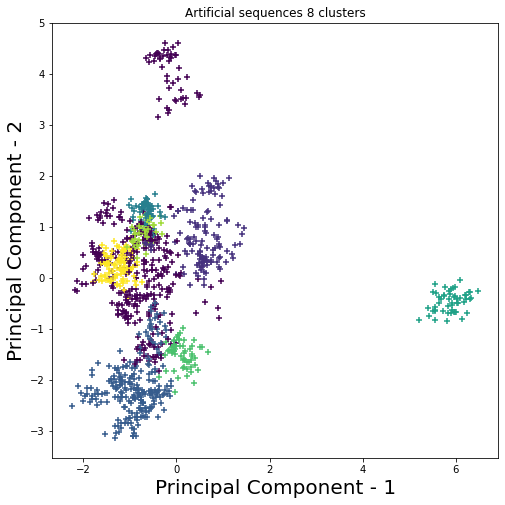

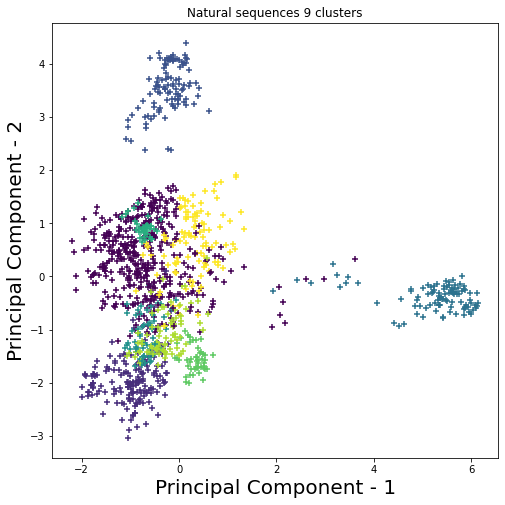

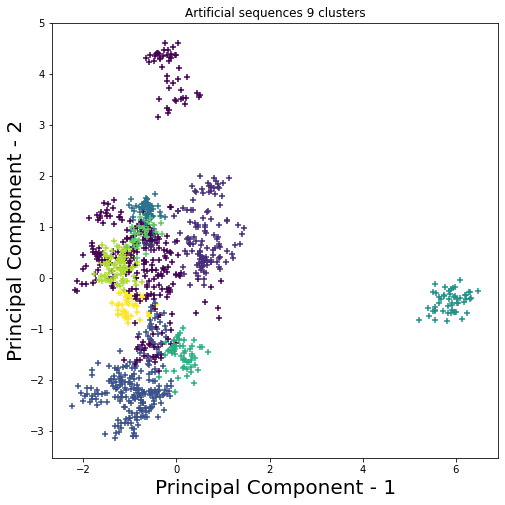

In [78]:
for i in range(8):
    compo_cluster(encoded_data_nat, pcs_nat, "Natural sequences " + str(i+2) + " clusters", i+2)
    compo_cluster(encoded_data_art, pcs_art, "Artificial sequences " + str(i+2) + " clusters", i+2)

#compo_cluster(encoded_data_unlab, pcs_unlab, "Unlabeled sequences", 2)

In [79]:
#Supervised learning: NN
import random
from keras import losses, optimizers, metrics, callbacks
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Input, Dense, Add, Dropout
                
params = {
        # https://keras.io/guides/sequential_model/
    'hidden_layers': {
            'units': 64,
            'activation': 'relu',
            'use_bias': True,
            'kernel_initializer': 'GlorotUniform',
            'kernel_regularizer': None,
            'bias_regularizer': 'l2',
            'activity_regularizer': None,
            'kernel_constraint': None,
            'bias_constraint': None
            },
    'compilation': {
            'optimizer': Adam(
                learning_rate=0.001
                ),
            'loss': losses.MeanSquaredError(),
            'metrics': [metrics.MeanSquaredError(), metrics.MeanAbsoluteError()],
        },
    'fit': {
        'batch_size': 32,
        'epochs': 100,
        'callbacks' : [
            callbacks.EarlyStopping(monitor='loss', patience=7), 
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]
            }
          }

#Need to shuffle the data
input_data = all_pcs
#input_data = all_pcs
output_data = all_lab

print(np.shape(input_data))
# Steps to shuffle:
joined_lists = list(zip(input_data, output_data))
random.shuffle(joined_lists) # Shuffle "joined_lists" in place
input_data, output_data = zip(*joined_lists) # Undo joining
input_data = np.array(input_data)
output_data = np.array(output_data)
print(np.shape(input_data))

def create_DNN(input_data, hidden_layers_params, dropout_rate):
    model = Sequential() 
    input_layer = Dense(32, input_shape=(np.shape(input_data)[1],)) 
    model.add(input_layer) 
    hidden_layer = Dense(**hidden_layers_params)
    model.add(hidden_layer)
    dropout_layer = Dropout(dropout_rate)
    model.add(dropout_layer)
    hidden_layer = Dense(**hidden_layers_params)
    model.add(hidden_layer) 
    output_layer = Dense(1, activation='sigmoid') 
    model.add(output_layer)
    
    return model

#Set up network
model = create_DNN(all_pcs, params['hidden_layers'], dropout_rate=0.25)
model.compile(**params['compilation'])

(2133, 500)
(2133, 500)


In [80]:
#Def fraction train/test/validation
fraction_train = 0.8
fraction_test = 0.1

stop_1 = int(fraction_train*len(output_data))
stop_2 = stop_1 + int(fraction_test*len(output_data))

X_train, Y_train = input_data[:stop_1], output_data[:stop_1]
X_test, Y_test = input_data[stop_1+1:stop_2], output_data[stop_1+1:stop_2]
X_validation, Y_validation = input_data[stop_2+1:], output_data[stop_2+1:]

print('Training network (this might take a while)...')
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    verbose=1,
    **params['fit']
)

Training network (this might take a while)...
Epoch 1/100
54/54 [==============================] - 1s 4ms/step - loss: 0.2142 - mean_squared_error: 0.2141 - mean_absolute_error: 0.4460 - val_loss: 0.1576 - val_mean_squared_error: 0.1575 - val_mean_absolute_error: 0.3583 - lr: 0.0010
Epoch 2/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1484 - mean_squared_error: 0.1482 - mean_absolute_error: 0.3198 - val_loss: 0.1278 - val_mean_squared_error: 0.1276 - val_mean_absolute_error: 0.2771 - lr: 0.0010
Epoch 3/100
54/54 [==============================] - 0s 1ms/step - loss: 0.1142 - mean_squared_error: 0.1140 - mean_absolute_error: 0.2508 - val_loss: 0.1252 - val_mean_squared_error: 0.1250 - val_mean_absolute_error: 0.2472 - lr: 0.0010
Epoch 4/100
54/54 [==============================] - 0s 1ms/step - loss: 0.0962 - mean_squared_error: 0.0960 - mean_absolute_error: 0.2130 - val_loss: 0.1317 - val_mean_squared_error: 0.1315 - val_mean_absolute_error: 0.2380 - lr: 0.0010
Ep

In [81]:
print('Number of epochs run:', len(history.history['loss']))

# Calculate and print scores
print('Evaluating model performance on test set...')
scores = model.evaluate(X_test, Y_test, verbose=0)

max_metrics_name_length = len(max(model.metrics_names, key=len))
print()
print(' Scores '.center(max_metrics_name_length + 13, '='))
line = '{:<%i} : {:.4e}' % max_metrics_name_length
for i in range(len(model.metrics_names)):
    print(line.format(model.metrics_names[i], scores[i]))
print()

Number of epochs run: 34
Evaluating model performance on test set...

============ Scores ============
loss                : 2.1045e-01
mean_squared_error  : 2.1034e-01
mean_absolute_error : 2.6071e-01




Test loss: 0.21044780313968658


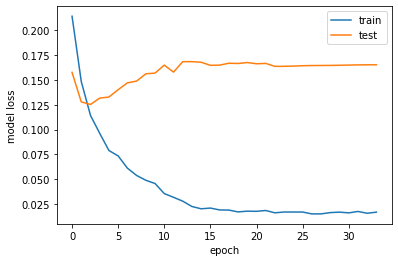

In [82]:
# print performance
print()
print('Test loss:', scores[0])

# look into training history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [68]:
#That's bad, so we'll try to optimize those parameters with a grid search
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from tensorflow.keras.optimizers import SGD, Adam

space={'learning_rate': hp.choice('learning_rate', [0.1, 1, 2, 3]),
       'dropout_rate': hp.choice('dropout_rate', [0., 0.1, 0.25, 0.4]),
       'units': hp.choice('units', [10, 20, 32, 64])
       #'momentum': hp.choice('momentum', [0.001, 0.1, 1])
       #'batch_size': hp.choice('batch_size', [16, 32, 48, 64]),
       #'patience_1': hp.choice('patience_1', [3, 5, 7, 10]),
       #'patience_2': hp.choice('patience_2', [3, 5, 7, 10])
    #'optimizer': hp.choice('optimizer', ['SGD','Adam'])
}

def objective(target):
    
    params = {
        # https://keras.io/guides/sequential_model/
    'hidden_layers': {
            'units': 64,
            'activation': 'relu',
            'use_bias': True,
            'kernel_initializer': 'GlorotUniform',
            'kernel_regularizer': None,
            'bias_regularizer': 'l2',
            'activity_regularizer': None,
            'kernel_constraint': None,
            'bias_constraint': None
            },
    'dropout_rate': 0.25,
    'compilation': {
            'optimizer': SGD(
                learning_rate=0.001,
                momentum=0.1
                ),
            'loss': losses.MeanSquaredError(),
            'metrics': [metrics.MeanSquaredError(), metrics.MeanAbsoluteError()],
            #'momentum': 0.
        },
    'fit': {
        'batch_size': 48,
        'epochs': 100,
        'callbacks' : [
            callbacks.EarlyStopping(monitor='loss', patience=10), 
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]
            }
          }

    # Create model and train it
    model = create_DNN(all_pcs, params['hidden_layers'], dropout_rate=0.25)
    model.compile(**params['compilation'])
    history = model.fit(
        X_train,
        Y_train,
        validation_data=(X_validation, Y_validation),
        verbose=0,
        **params['fit']
        )
    
    loss=history.history['val_loss'][-1]
    
    return {'loss': loss, 'status': STATUS_OK }

trials=Trials()
best = fmin(objective,
            space, 
            algo=tpe.suggest, 
            trials=trials, 
            max_evals=100
            )

print ("Best result:", best)
print (trials.best_trial)

 16%|█▌        | 16/100 [01:37<08:32,  6.10s/trial, best loss: 0.20936749875545502]


KeyboardInterrupt: 

In [90]:
from tensorflow.keras.optimizers import SGD, Adam
#Now retrain the network with those optimal parameters
params = {
        # https://keras.io/guides/sequential_model/
    'hidden_layers': {
            'units': 64,
            'activation': 'relu',
            'use_bias': True,
            'kernel_initializer': 'GlorotUniform',
            'kernel_regularizer': None,
            'bias_regularizer': 'l2',
            'activity_regularizer': None,
            'kernel_constraint': None,
            'bias_constraint': None
            },
    'dropout_rate': 0.25,
    'compilation': {
            'optimizer': SGD(
                learning_rate=0.001,
                momentum=0.1
                ),
            'loss': losses.MeanSquaredError(),
            'metrics': [metrics.MeanSquaredError(), metrics.MeanAbsoluteError()],
            #'momentum': 0.
        },
    'fit': {
        'batch_size': 48,
        'epochs': 100,
        'callbacks' : [
            callbacks.EarlyStopping(monitor='loss', patience=7), 
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)]
            }
          }

#Set up network
model = create_DNN(all_pcs, params['hidden_layers'], params['dropout_rate'])
model.compile(**params['compilation'])
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_validation, Y_validation),
    verbose=1,
    **params['fit']
)

print('Number of epochs run:', len(history.history['loss']))

# Calculate and print scores
print('Evaluating model performance on test set...')
scores = model.evaluate(X_test, Y_test, verbose=0)

max_metrics_name_length = len(max(model.metrics_names, key=len))
print()
print(' Scores '.center(max_metrics_name_length + 13, '='))
line = '{:<%i} : {:.4e}' % max_metrics_name_length
for i in range(len(model.metrics_names)):
    print(line.format(model.metrics_names[i], scores[i]))
print()

# print performance
print()
print('Test loss:', scores[0])

# look into training history

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Epoch 1/100


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_26" is incompatible with the layer: expected shape=(None, 500), found shape=(None, 1920)


(6269, 500)
(6269, 1)
However, we know that this has a fail rate of at least 25%
There's an estimated 43 % functional sequences


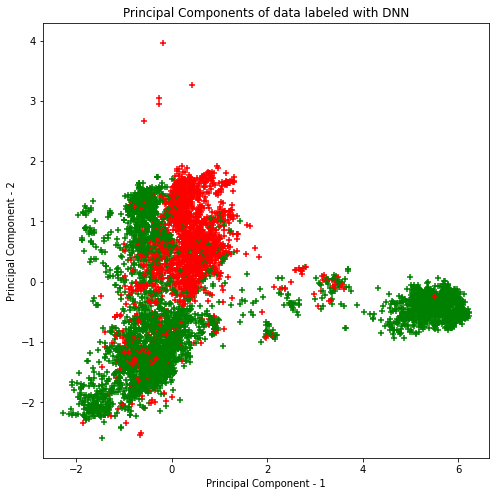

In [84]:
print(np.shape(unlab_pcs))
pred_labels = model.predict(unlab_pcs)
print(np.shape(pred_labels))

#red => 0 => functional_false; green => 1 => functional_true
colors = ['red','green']
groups = ['functional_false', 'functional_true']

fig = plt.figure(figsize=(8,8))
plt.scatter(unlab_pcs[:,0], unlab_pcs[:,1], c=pred_labels, marker = '+', label=groups,
            cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('Principal Component - 1')
plt.ylabel('Principal Component - 2')
#plt.legend(loc=2)
plt.title("Principal Components of data labeled with DNN")

print("However, we know that this has a fail rate of at least 25%")

print("There's an estimated " + str(int(np.sum(pred_labels)*100/6269)) + " % functional sequences")

As expected, this does not yield very good results: we have too few data (2133 units of dimension 500!)
But it was fun coding a NN, and it's good practice. Hoxever, fun is good, so we should use a better suited method: let's use random forest
(What follows relies heavily on the asociated Jupyter notebook)

In [85]:
#Apply Random Forest
#This is the random forest classifier
from sklearn.ensemble import RandomForestClassifier
#This is the extreme randomized trees
from sklearn.ensemble import ExtraTreesClassifier
#import time to see how perforamance depends on run time
import time
import warnings
#Comment to turn on warnings
warnings.filterwarnings("ignore")

input_data = all_lab_data
output_data = all_lab

# Steps to shuffle:
joined_lists = list(zip(input_data, output_data))
random.shuffle(joined_lists) # Shuffle "joined_lists" in place
input_data, output_data = zip(*joined_lists) # Undo joining
input_data = np.array(input_data)
output_data = np.array(output_data)
print(np.shape(input_data))

#Def fraction train/test/validation
fraction_train = 0.8
stop_1 = int(fraction_train*len(output_data))

X_train, Y_train = input_data[:stop_1], output_data[:stop_1]
X_test, Y_test = input_data[stop_1+1:], output_data[stop_1+1:]

#We will check 

min_estimators = 10
max_estimators = 101
classifer = RandomForestClassifier # BELOW WE WILL CHANGE for the case of extremly randomized forest 

n_estimator_range=np.arange(min_estimators, max_estimators, 10)
leaf_size_list=[2,3, 4, 5, 6, 7, 8]

m=len(n_estimator_range)
n=len(leaf_size_list)

#Allocate Arrays for various quantities

RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_test_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_list):
    # Define Random Forest Classifier
    myRF_clf = classifer(
        n_estimators=min_estimators,
        max_depth=None, 
        min_samples_split=leaf_size, # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True # this ensures that you add estimators without retraining everything
    )
    for j, n_estimator in enumerate(n_estimator_range):
        
        print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))
        
        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(X_train, Y_train)
        run_time[i,j] = time.time() - start_time

    # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(X_train,Y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_test_accuracy[i,j]=myRF_clf.score(X_test,Y_test)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_test_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}'.format("time (s)","train score", "OOB estimate","test score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}'.format(*result))

(2133, 1920)
n_estimators: 10, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.0988         0.9889         0.7462         0.7746         
n_estimators: 20, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1002         0.9988         0.7685         0.7723         
n_estimators: 30, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1262         1.0000         0.7767         0.7770         
n_estimators: 40, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1497         1.0000         0.7778         0.7840         
n_estimators: 50, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1522         1.0000         0.7831         0.7770         
n_estimators: 60, leaf_size: 2
time (s)       train score    OOB estimate   test score     
0.1745         1.0000         0.7902         0.7746         
n_estimators: 70, leaf_size: 2
time (s)       train score    OOB esti

time (s)       train score    OOB estimate   test score     
0.1322         0.9648         0.7825         0.7817         
n_estimators: 60, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1448         0.9678         0.7890         0.7958         
n_estimators: 70, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1577         0.9695         0.7866         0.7864         
n_estimators: 80, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1634         0.9713         0.7878         0.7981         
n_estimators: 90, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1740         0.9730         0.7919         0.7911         
n_estimators: 100, leaf_size: 7
time (s)       train score    OOB estimate   test score     
0.1846         0.9725         0.7902         0.7911         
n_estimators: 10, leaf_size: 8
time (s)       train score    OOB estimate   test score     
0.0767         0.943

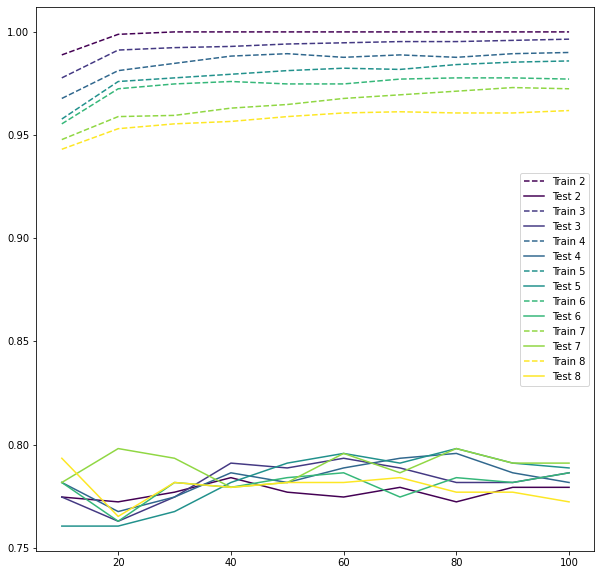

In [86]:
plt.figure(figsize=(10,10))
color = plt.cm.viridis(np.linspace(0, 1, len(leaf_size_list)))
for i, leaves in enumerate(leaf_size_list) :
    plt.plot()
    plt.plot(n_estimator_range,RFC_train_accuracy[i],'--', c=color[i], label='Train '+str(leaves))
    plt.plot(n_estimator_range,RFC_test_accuracy[i], c=color[i], label='Test '+str(leaves))
    plt.legend()
plt.show()

In [87]:
myRF_clf = classifer(
    n_estimators=min_estimators,
    max_depth=None, 
    min_samples_split=7, # minimum number of sample per leaf
    oob_score=True,
    random_state=0,
    warm_start=True # this ensures that you add estimators without retraining everything
)

myRF_clf.set_params(n_estimators=35)
myRF_clf.fit(X_train, Y_train)

predictions = myRF_clf.predict(np.array(encoded_data_unlab))
#functionality = [1 if predictions[0]==0 else 0 for prediction in predictions]

With 512 components, we keep 95% of the variance!
With the first 2 components, we only keep 7.63879085268583% of the variance
There's an estimated 41 % functional sequences
Again, there's an 80% accuracy


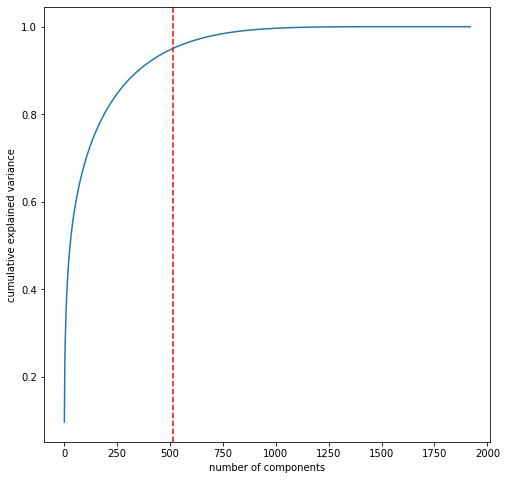

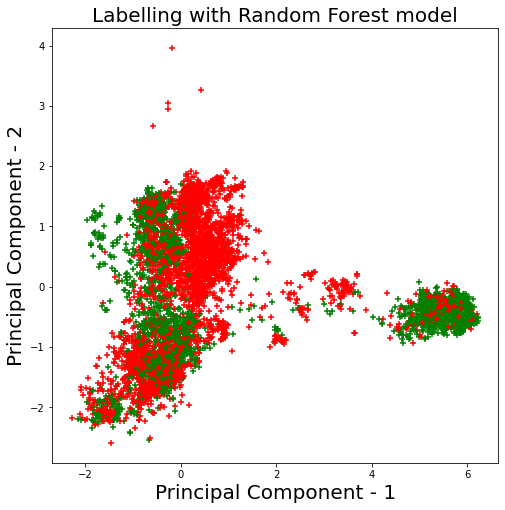

In [88]:
pcs_pred = apply_PCA(encoded_data_unlab)
visualize_pcs(pcs_pred, predictions, "Labelling with Random Forest model")

print("There's an estimated " + str(int(np.sum(predictions)*100/6269)) + " % functional sequences")
print("Again, there's an 80% accuracy")